In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap

import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape
import seaborn as sns
import pandas as pd 

import indices_no_leap as ii

# Figure 3

In [2]:
gcm_names=['MIROC_ESM','CanESM2','HadGEM_AO','GFDL_CM3']
i = 1
gcm_name=gcm_names[i]
map_bounds=[65, 40, 100, 5]

print('preparing plots for ' + gcm_name)


preparing plots for CanESM2


## Import data

In [3]:
output_figname = ''
path_out_IMD = '/home/vikram/BCSD_data/India_P_BCSDd'+output_figname

In [4]:
gcm_meta=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_name+'.npy',allow_pickle=True)
Nyears_train = gcm_meta.item()['Nyears_train']


imd_train=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_train.npy'))
imd_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_pred.npy'))[365*Nyears_train:-365*5]


gcm_train=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_train.npy'))
gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_pred.npy'))[365*Nyears_train:-365*5]

out_id='pre_'+gcm_name 

bcsd_gcm_train=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_historical'+out_id+'.npy'))[:365*Nyears_train]
bcsd_gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_historical'+out_id+'.npy'))[365*Nyears_train:-365*5]

st=gcm_meta.item()['st']
en=gcm_meta.item()['en']

lat_obs=gcm_meta.item()['lat_obs']
lat_gcm_01=gcm_meta.item()['lat_gcm']
lon_obs=gcm_meta.item()['lon_obs']
lon_gcm_01=gcm_meta.item()['lon_gcm']
mask=gcm_meta.item()['mask']


N1=imd_test.shape[1]
N2=imd_test.shape[2]


j=0
if output_figname == '_eqm':
    out_id='pre_rnd_'+str(0)   
else:
    out_id='pre_rnd_new_'+str(10)   
bcsd_rnd_train=uu.correct_nan_inf_neg((np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy')))[:365*Nyears_train]
bcsd_rnd_test=uu.correct_nan_inf_neg((np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy')))[365*Nyears_train:-365*5]
# /home/vikram/BCSD_data/India_P_BCSDd/detrended_BC_outputs_historicalpre_MPI_ESM_MR.npy
data_gf_train=np.zeros(imd_train.shape)
data_gf_test=np.zeros(imd_test.shape)

for i in range(gcm_train.shape[0]):
  data_gf_train[i,:,:]=uu.regrid(gcm_train[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
  data_gf_test[i,:,:]=uu.regrid(gcm_test[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
  




In [5]:
def prints(*args):
    for arg in args:
        print(arg.shape)

In [6]:
prints(imd_train,imd_test,data_gf_train,data_gf_test,bcsd_gcm_train,bcsd_gcm_test,bcsd_rnd_train,bcsd_rnd_test)

(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)
(18250, 33, 35)


## Checking imported data

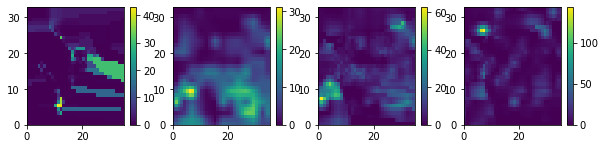

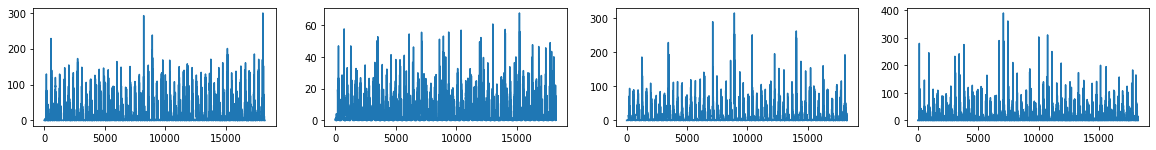

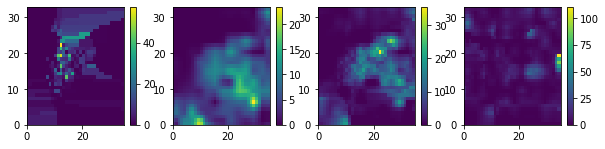

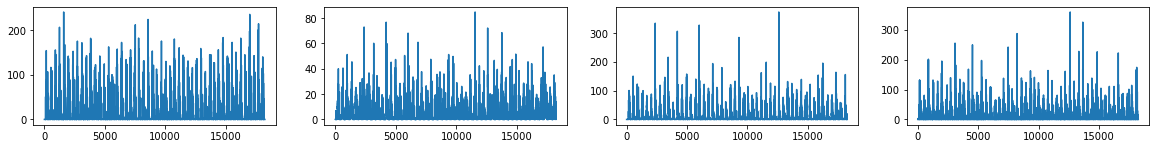

In [7]:

data_train = [imd_train,data_gf_train,bcsd_gcm_train,bcsd_rnd_train]
data_test = [imd_test,data_gf_test,bcsd_gcm_test,bcsd_rnd_test]


plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.pcolor(data_train[i][250,:,:])
  plt.colorbar()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.plot(data_train[i][:,7,7])
    
plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.pcolor(data_test[i][250,:,:])
  plt.colorbar()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.plot(data_test[i][:,7,7])



In [8]:
data_gf_train.shape

(18250, 33, 35)

## Compute indices

In [9]:
from tqdm import tqdm
def check_for_nans_infs_zeros(data_sts):
    print('Nans:',np.sum(np.isnan(data_sts)))
    print('Infs:' ,np.sum(np.isinf(data_sts)))
    print('Zeros:',np.sum((data_sts==0)))
    
    
def spatial_ind(func,data_all,mask):
  N=data_all[0].shape[0]
  N1=data_all[0].shape[1]
  N2=data_all[0].shape[2]
  Nyears  =  int(N/365 )
  D=len(data_all)
  calc_index=np.zeros((D,N1,N2))
  for d in tqdm(range(D)):
        for i in range(N1):
          for j in range(N2):
            if mask[i,j] == 0:
                calc_index[d,i,j]=np.nanmean(func(data_all[d][:,i,j],Nyears))
  return calc_index

def spatial_ind_var(func,data_all,mask):
  N=data_all[0].shape[0]
  N1=data_all[0].shape[1]
  N2=data_all[0].shape[2]
  Nyears  =  int(N/365 )
  D=len(data_all)
  calc_index=np.zeros((D,N1,N2))
  for d in tqdm(range(D)):
        for i in range(N1):
          for j in range(N2):
            if mask[i,j] == 0:
                calc_index[d,i,j]=np.nanvar(func(data_all[d][:,i,j],Nyears))
  return calc_index



In [13]:
## R50mm
P_ann_train=spatial_ind(ii.sum_annualy,data_train,mask)
P_ann_test=spatial_ind(ii.sum_annualy,data_test,mask)

IAV_train=spatial_ind_var(ii.sum_annualy,data_train,mask)
IAV_test=spatial_ind_var(ii.sum_annualy,data_test,mask)

R50mmindic_train=spatial_ind(ii.R20mm_annualy,data_train,mask)
R50mmindic_test=spatial_ind(ii.R20mm_annualy,data_test,mask)

### Rx1day
Rx1dayindic_train=spatial_ind(ii.Rx1day_annualy,data_train,mask)
Rx1dayindic_test=spatial_ind(ii.Rx1day_annualy,data_test,mask)

### CDD
CDDindic_train=spatial_ind(ii.CDD_annualy,data_train,mask)
CDDindic_test=spatial_ind(ii.CDD_annualy,data_test,mask)

## R99p
R99pindic_train=spatial_ind(ii.R99p_annualy,data_train,mask)
R99pindic_test=spatial_ind(ii.R99p_annualy,data_test,mask)





100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


In [18]:
np.save("./data_spatial/P_ann_test_hist",P_ann_test)
np.save("./data_spatial/IAV_test_hist",IAV_test)
np.save("./data_spatial/R50mmindic_test_hist",R50mmindic_test)
np.save("./data_spatial/Rx1dayindic_test_hist",Rx1dayindic_test)
np.save("./data_spatial/CDDindic_test_hist",CDDindic_test)
np.save("./data_spatial/R99pindic_test_hist",R99pindic_test)
np.save("./data_spatial/mask",mask)
np.save("./data_spatial/lat_obs",lat_obs.data)
np.save("./data_spatial/lon_obs",lon_obs.data)



## Figure 3

In [11]:
def map_plot_cyl_final(data_lat_x_lon,lat_cen,lon_cen,map_bounds,clab,cmap,y_limit,ax,mp_spacing=10,subplot_iter=1,loff=1,coff=1,ex='both'):

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2],  llcrnrlat=map_bounds[3])


  xx, yy = meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon
  map.pcolor(xx, yy, data_lat_x_lon,cmap=cmap)
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  if loff==0:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes
  else:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[0,0,0,0], linewidth=1.0) #latitudes
  cbar = map.colorbar(extend=ex)
  #cbar.ax.set_yticklabels(['0','1','2','>3'])
  cbar.set_label(clab, rotation=90)
  plt.clim(y_limit)

  if coff==1:
    cbar.remove()

  #map.drawcountries(linewidth=1)
  map.readshapefile('/home/vikram/BCSD_Shapefiles/ind', 'IND', linewidth=1.0)

  map.drawcoastlines(linewidth=1)
  lxx=0.02
  lyy=0.98
  lcol='k'
  lsize=24
  lfamily='Tahoma'
  lweight=800
  plt.text(lxx, lyy, chr(subplot_iter+96), horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,fontweight=lweight,
           fontfamily=lfamily,fontsize=lsize,color=lcol)

## Training data

Text(0.08, 0.65, 'IAV')

findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


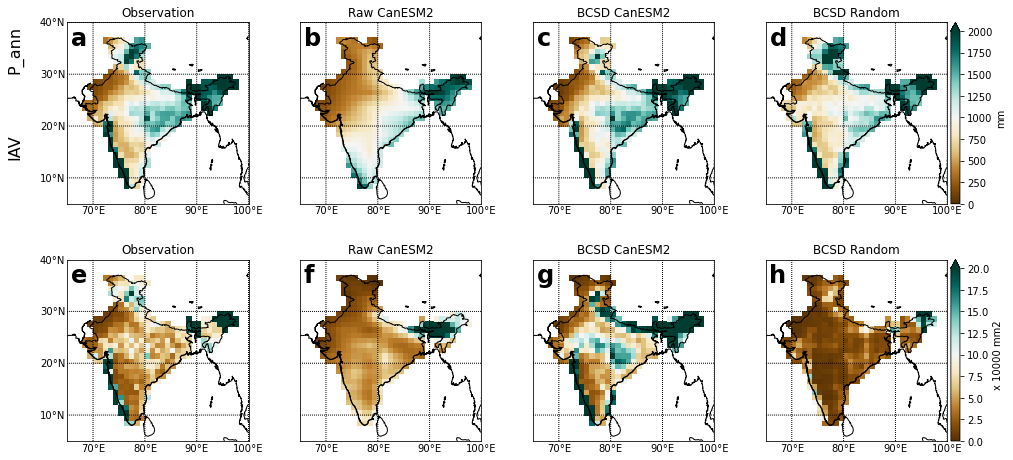

In [12]:
dapa=[
  P_ann_train[0,:,:],
  P_ann_train[1,:,:],
  P_ann_train[2,:,:],
  P_ann_train[3,:,:],
  IAV_train[0,:,:]/10000,
  IAV_train[1,:,:]/10000,
  IAV_train[2,:,:]/10000,
  IAV_train[3,:,:]/10000,
 ]

y_limits=[[0,2000],
          [0,20],]

labels=['mm','x 10000 mm2']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['P_ann','IAV']

cmaps=['BrBG','BrBG',]
# cmaps=['YlGnBu','YlGnBu','YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']

ex='max'

fig=plt.figure(figsize=(16,8))
for rr in range(2):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(2,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)




# plt.savefig('./normal_hist/MEAN_IAV_'+gcm_name+output_figname+'_train.svg')
# plt.savefig('./normal_hist/MEAN_IAV_'+gcm_name+output_figname+'_train.png',facecolor = 'w')


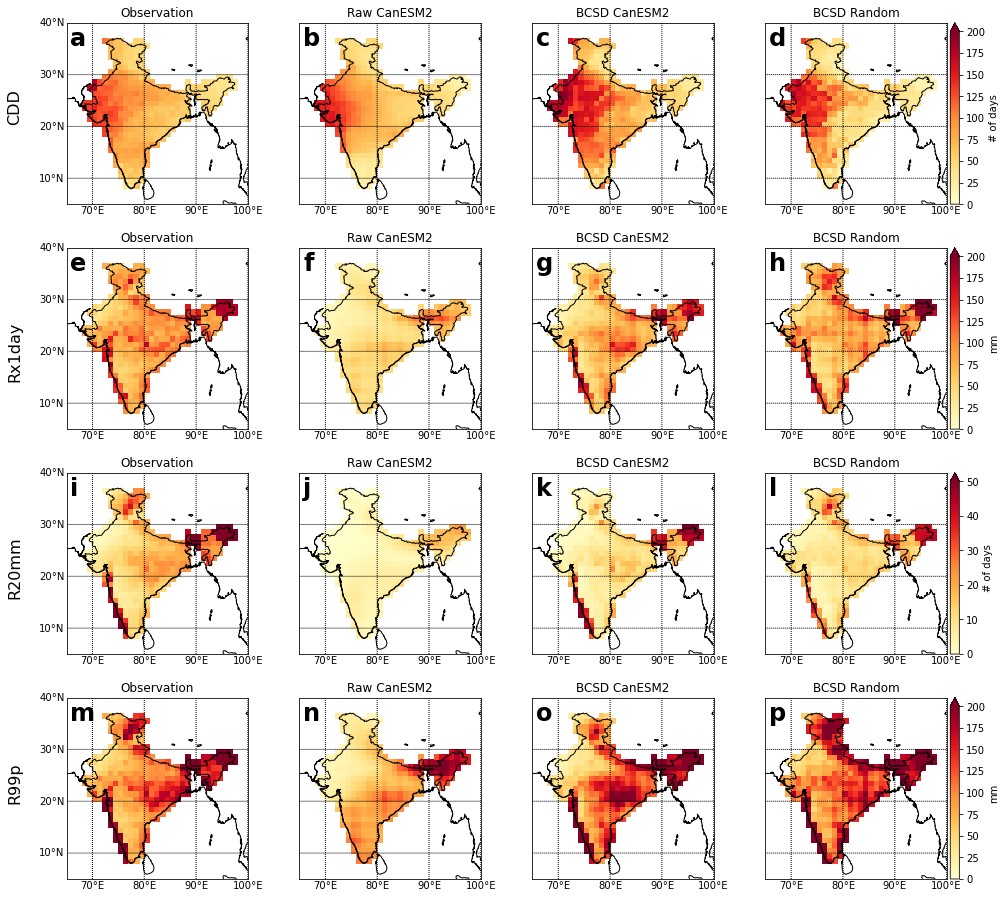

In [24]:
dapa=[
  CDDindic_train[0,:,:],
  CDDindic_train[1,:,:],
  CDDindic_train[2,:,:],
  CDDindic_train[3,:,:],
  Rx1dayindic_train[0,:,:],
  Rx1dayindic_train[1,:,:],
  Rx1dayindic_train[2,:,:],
  Rx1dayindic_train[3,:,:],
  R50mmindic_train[0,:,:],
  R50mmindic_train[1,:,:],
  R50mmindic_train[2,:,:],
  R50mmindic_train[3,:,:],
  R99pindic_train[0,:,:],
  R99pindic_train[1,:,:],
  R99pindic_train[2,:,:],
  R99pindic_train[3,:,:],
 ]

y_limits=[[0,200],
          [0,200],
          [0,50],
          [0,200],
          [0,200]]

labels=['# of days','mm','# of days','mm','# of days']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['CDD','Rx1day','R20mm','R99p','HI32']
cmaps=['YlOrRd','YlOrRd','YlOrRd','YlOrRd','YlOrRd']
# cmaps=['YlGnBu','YlGnBu','YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']

ex='max'

fig=plt.figure(figsize=(16,20))
for rr in range(4):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(5,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.35, titlesy[3], va='center', ha='center', rotation='vertical', fontsize=16)
# fig.text(0.08, 0.2, titlesy[4], va='center', ha='center', rotation='vertical', fontsize=16)

# plt.savefig('./Figures/Figure3/temps/extended_'+gcm_name+output_figname+'_train.svg')
# plt.savefig('./Figures/Figure3/temps/extended_'+gcm_name+output_figname+'_train.jpg',dpi=150)
            
            
# plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figure_new_auroop/Figure2/extended_'+gcm_name+output_figname+'_train.svg')

plt.savefig('./normal_hist/Extremes_'+gcm_name+output_figname+'_train.svg')
plt.savefig('./normal_hist/Extremes_'+gcm_name+output_figname+'_train.png',facecolor = 'w')




## Testing Data

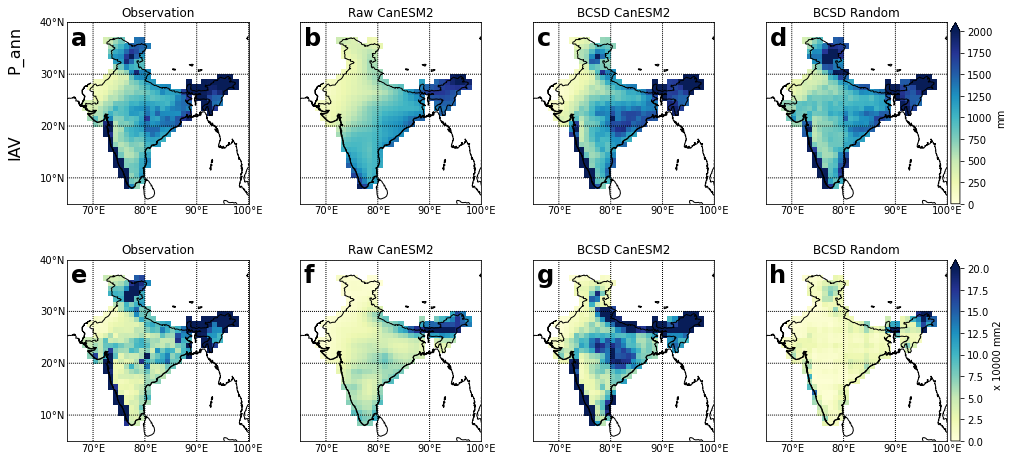

In [25]:
dapa=[
  P_ann_test[0,:,:],
  P_ann_test[1,:,:],
  P_ann_test[2,:,:],
  P_ann_test[3,:,:],
  IAV_test[0,:,:]/10000,
  IAV_test[1,:,:]/10000,
  IAV_test[2,:,:]/10000,
  IAV_test[3,:,:]/10000,
 ]

y_limits=[[0,2000],
          [0,20],]

labels=['mm','x 10000 mm2']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['P_ann','IAV']

cmaps=['BrBG','BrBG',]
cmaps=['YlGnBu','YlGnBu']#,'YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']

ex='max'

fig=plt.figure(figsize=(16,8))
for rr in range(2):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(2,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)


plt.savefig('./normal_hist/MEAN_IAV_'+gcm_name+output_figname+'_test.svg')
plt.savefig('./normal_hist/MEAN_IAV_'+gcm_name+output_figname+'_test.png',facecolor = 'w')



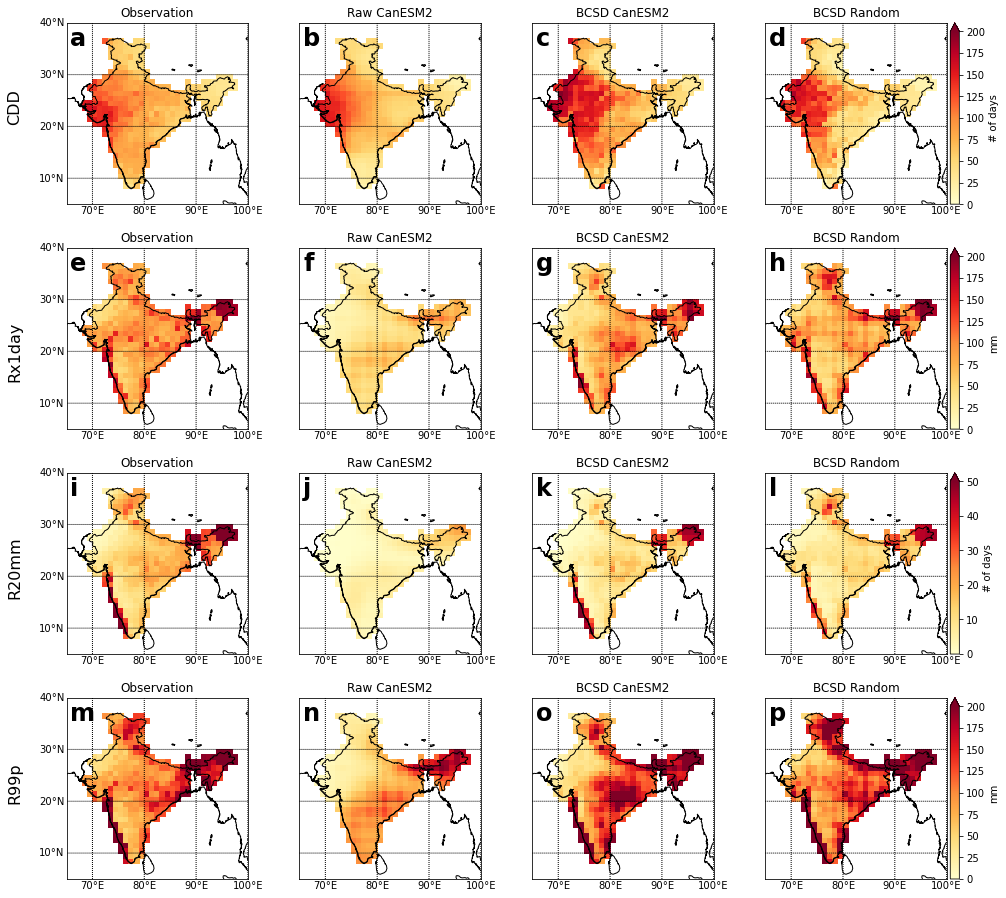

In [26]:
dapa=[
  CDDindic_test[0,:,:],
  CDDindic_test[1,:,:],
  CDDindic_test[2,:,:],
  CDDindic_test[3,:,:],
  Rx1dayindic_test[0,:,:],
  Rx1dayindic_test[1,:,:],
  Rx1dayindic_test[2,:,:],
  Rx1dayindic_test[3,:,:],
  R50mmindic_test[0,:,:],
  R50mmindic_test[1,:,:],
  R50mmindic_test[2,:,:],
  R50mmindic_test[3,:,:],
  R99pindic_test[0,:,:],
  R99pindic_test[1,:,:],
  R99pindic_test[2,:,:],
  R99pindic_test[3,:,:],
 ]


y_limits=[[0,200],
          [0,200],
          [0,50],
          [0,200],
          [0,200]]

labels=['# of days','mm','# of days','mm','# of days']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['CDD','Rx1day','R20mm','R99p','HI32']
cmaps=['YlOrRd','YlOrRd','YlOrRd','YlOrRd','YlOrRd']
# cmaps=['YlGnBu','YlGnBu','YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']
ex='max'

fig=plt.figure(figsize=(16,20))
for rr in range(4):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(5,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.35, titlesy[3], va='center', ha='center', rotation='vertical', fontsize=16)
# fig.text(0.08, 0.2, titlesy[4], va='center', ha='center', rotation='vertical', fontsize=16)

# plt.savefig('./Figures/Figure3/temps/extended_'+gcm_name+output_figname+'_test.svg',facecolor='w')
# plt.savefig('./Figures/Figure3/temps/extended_'+gcm_name+output_figname+'_test.jpg',dpi=150)


# plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figure_new_auroop/Figure2/extended_'+gcm_name+output_figname+'_test.svg')


plt.savefig('./normal_hist/Extremes_'+gcm_name+output_figname+'_test.svg')
plt.savefig('./normal_hist/Extremes_'+gcm_name+output_figname+'_test.png',facecolor = 'w')






# S scores

def S_score_2D(data_ref, data_model,mask_inf):
    # mask is true for exterior values
    data_1 = data_ref
    data_2 = data_model 
    ind_1 = np.isnan(data_1)
    ind_2 = np.isnan(data_2)
    data_1[ind_2] = np.nan
    data_2[ind_1] = np.nan
    data_1[mask_inf == True] = np.nan
    data_2[mask_inf == True] = np.nan

    data_1 = data_1.flatten()
    data_2 = data_2.flatten()
    
    data_1 =  np.delete(data_1,np.isnan(data_1))
    data_2 =  np.delete(data_2,np.isnan(data_2))
    R = np.corrcoef(data_1,data_2)[0,1]

    SDR = np.std(data_2)/np.std(data_1)

    S_score = (1+R)**4  / ( 4 * (SDR + 1 / SDR)**2 )
    
    
    return S_score

D=4
N_index= 4
S_score_matrix = np.zeros((N_index,D))
for itr,index in enumerate([CDDindic_train,Rx1dayindic_train,R50mmindic_train,R99pindic_train]):
    for d in range(D):
        S_score_matrix[itr,d] = (S_score_2D(index[0,:,:],index[d,:,:],mask))
        
        
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','B','R'],
          yticklabels=['CDD','Rx1day','R50mm','R99p'],vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)
plt.savefig('./Figures/Figure3/temps/Score_extended_'+gcm_name+output_figname+'_train.svg')
plt.savefig('./Figures/Figure3/temps/Score_extended_'+gcm_name+output_figname+'_train.jpg',dpi=150)

plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figure_new_auroop/Figure2/Score_extended_'+gcm_name+output_figname+'_train.svg')

plt.figure()
D=4
N_index= 4
S_score_matrix = np.zeros((N_index,D))
for itr,index in enumerate([CDDindic_test,Rx1dayindic_test,R50mmindic_test,R99pindic_test]):
    for d in range(D):
        S_score_matrix[itr,d] = (S_score_2D(index[0,:,:],index[d,:,:],mask))
        
        
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','B','R'],
          yticklabels=['CDD','Rx1day','R50mm','R99p'],vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)
plt.savefig('./Figures/Figure3/temps/Score_extended_'+gcm_name+output_figname+'_test.svg')
plt.savefig('./Figures/Figure3/temps/Score_extended_'+gcm_name+output_figname+'_test.jpg',dpi=150)
plt.savefig('/home/vikram/Dropbox/BCSD Work/03_Figures/Figure_new_auroop/Figure2/Score_extended_'+gcm_name+output_figname+'_test.svg')

